Copyright © 2020, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Fleet Maintenance: Build and Import Trained Models into SAS Model Manager

This notebook provides an example of how to build and train a Python model and then import the model into SAS Model Manager using the fleet maintenance data set. Lines of code that must be modified by the user, such as directory paths are noted with the comment "_Changes required by user._".

_**Note:** If you download only this notebook and not the rest of the repository, you must also download the fleet_maintenance.csv from the data folder in the examples directory. These files are used when executing this notebook example._

Here are the steps shown in this notebook:

1. Import and review data and preprocess for model training.
2. Build, train, and access a decision tree, random forest, and gradient boosting model.
3. Serialize the models into separate pickle files.
4. Write the metadata JSON files needed for importing into SAS Model Manager as well as optional files for fit statistics and ROC/Lift charts.
4. Write a score code Python file for model scoring.
5. Zip the pickle, JSON, and score code files into an archive file.
6. Import the ZIP archive file to SAS Model Manager via the Session object and relevant function call.

### Python Package Imports

In [1]:
# Dataframes for data manipulations
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# Mathematical calculations and array handling
import numpy as np

# Data partitioning for TRAIN and TEST data sets
from sklearn.model_selection import train_test_split
# Decision tree, random forest, and gradient boosting models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# Model assessments 
from sklearn.metrics import classification_report, confusion_matrix

# Embedded plotting
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

# Pathing support
from pathlib import Path

# sasctl interface for importing models
import sasctl.pzmm as pzmm
from sasctl import Session
from sasctl.services import model_repository as modelRepo

### Import and Review Data Set

In [2]:
fleetData = pd.read_csv('data/fleet_maintenance.csv',sep= ',')
fleetData.shape

(8307, 40)

In [3]:
fleetData.head()

,Maintenance_flag,Speed_sensor,Vibration,Engine_Load,Coolant_Temp,Intake_Pressure,Engine_RPM,Speed_OBD,Intake_Air,Flow_Rate,...,CO2_emission,Fuel_level,Oil_life,Vibration_alert,VibrationAlert_Total,Vibration_Recent,Turbo_alert,Emission_alert,Fog_control,Engine_control
0,0,35,249.188875,21.568628,88,116,1115.5,35,10,18.33,...,0,0,0,1,123,12,1,1,1,1
1,0,142,243.236572,20.392157,88,135,1782.5,142,16,35.41,...,0,0,0,1,123,12,1,1,1,1
2,0,128,244.015378,43.529410,81,109,1588.0,128,9,27.08,...,0,0,0,1,123,12,1,1,1,1
3,0,117,244.627297,99.607840,89,128,1899.5,117,13,36.99,...,0,0,0,1,123,12,1,1,1,1
4,0,98,245.684248,73.333336,89,123,1230.5,98,9,21.63,...,0,0,0,1,123,12,1,1,1,1


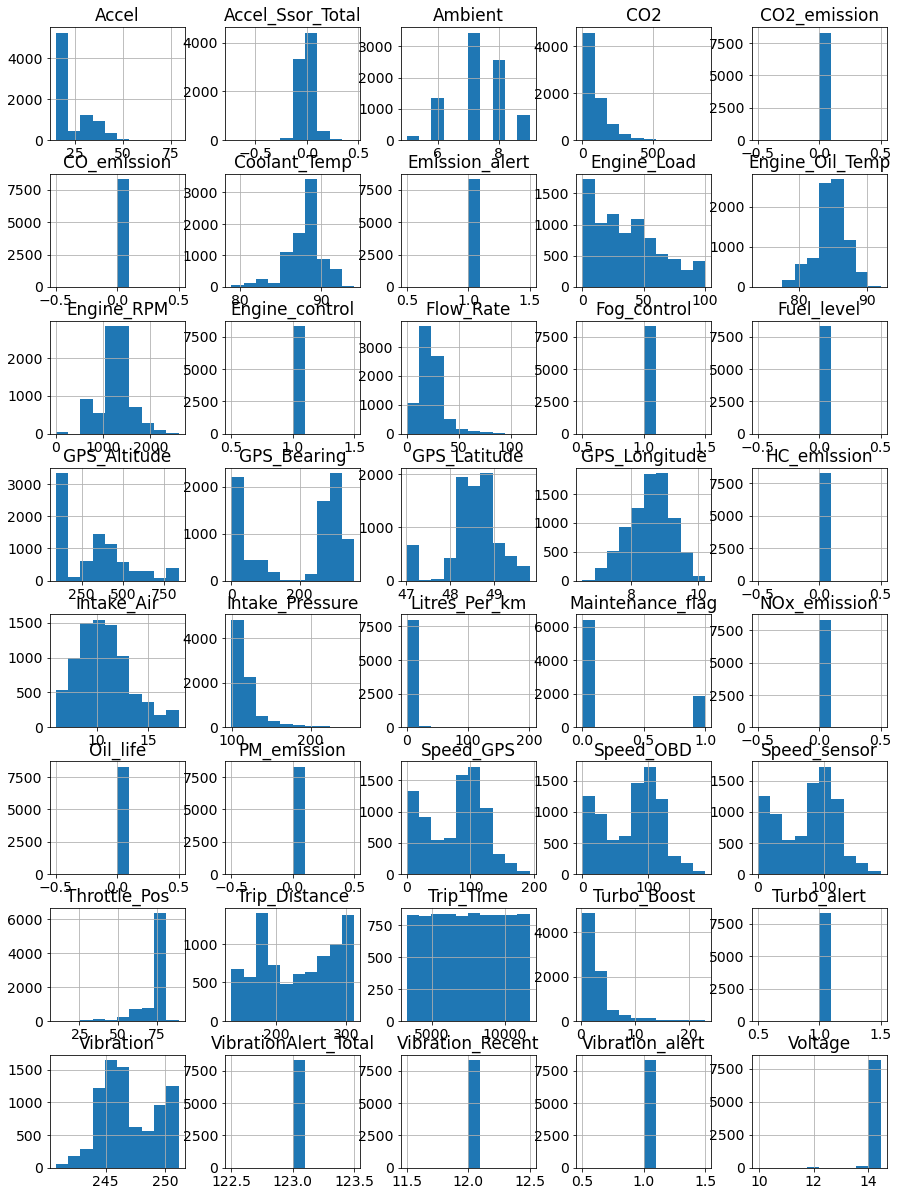

In [4]:
fleetData.hist(figsize=(15,75), layout=(28, 5));

In [5]:
fleetData.columns

Index(['Maintenance_flag', 'Speed_sensor', 'Vibration', 'Engine_Load',
       'Coolant_Temp', 'Intake_Pressure', 'Engine_RPM', 'Speed_OBD',
       'Intake_Air', 'Flow_Rate', 'Throttle_Pos', 'Voltage', 'Ambient',
       'Accel', 'Engine_Oil_Temp', 'Speed_GPS', 'GPS_Longitude',
       'GPS_Latitude', 'GPS_Bearing', 'GPS_Altitude', 'Turbo_Boost',
       'Trip_Distance', 'Litres_Per_km', 'Accel_Ssor_Total', 'CO2',
       'Trip_Time', 'CO_emission', 'HC_emission', 'PM_emission',
       'NOx_emission', 'CO2_emission', 'Fuel_level', 'Oil_life',
       'Vibration_alert', 'VibrationAlert_Total', 'Vibration_Recent',
       'Turbo_alert', 'Emission_alert', 'Fog_control', 'Engine_control'],
      dtype='object')

### Preprocess Data

In [6]:
predictorColumns = ['Speed_sensor', 'Vibration', 'Engine_Load', 'Coolant_Temp', 'Intake_Pressure', 'Engine_RPM', 'Speed_OBD',
       'Intake_Air', 'Flow_Rate', 'Throttle_Pos', 'Voltage', 'Ambient', 'Accel', 'Engine_Oil_Temp', 'Speed_GPS', 
       'GPS_Longitude', 'GPS_Latitude', 'GPS_Bearing', 'GPS_Altitude', 'Turbo_Boost', 'Trip_Distance', 'Litres_Per_km',
       'Accel_Ssor_Total', 'CO2', 'Trip_Time', 'CO_emission', 'HC_emission', 'PM_emission', 'NOx_emission', 'CO2_emission',
       'Fuel_level', 'Oil_life', 'Vibration_alert', 'VibrationAlert_Total', 'Vibration_Recent', 'Turbo_alert', 
       'Emission_alert', 'Fog_control', 'Engine_control']

targetColumn = 'Maintenance_flag'
x = fleetData[predictorColumns]
y = fleetData[targetColumn]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, random_state=42)

# For missing values, impute the data set's mean value
xTest.fillna(xTest.mean(), inplace=True)
xTrain.fillna(xTrain.mean(), inplace=True)

### Create, Train, and Assess Model

In [7]:
treeModel = DecisionTreeClassifier(random_state=42, min_samples_leaf=25)
treeModel = treeModel.fit(xTrain, yTrain)

forestModel = RandomForestClassifier(random_state=42)
forestModel = forestModel.fit(xTrain, yTrain)

gradientModel = GradientBoostingClassifier(random_state=42)
gradientModel = gradientModel.fit(xTrain, yTrain)

In [8]:
def sortFeatureImportance(model, xData):
    features = {}
    for importance, name in sorted(zip(model.feature_importances_, xData.columns), reverse=True):
        features[name] = str(np.round(importance*100, 2)) + '%'
    return features

importances = pd.DataFrame.from_dict(sortFeatureImportance(treeModel, xTrain), orient='index').rename(columns={0: 'DecisionTree'})
importances['RandomForest'] = pd.DataFrame.from_dict(sortFeatureImportance(forestModel, xTrain), orient='index')
importances['GradientBoosting'] = pd.DataFrame.from_dict(sortFeatureImportance(gradientModel, xTrain), orient='index')
importances

,DecisionTree,RandomForest,GradientBoosting
Trip_Distance,27.26%,9.99%,24.89%
Speed_GPS,21.48%,6.91%,11.23%
Trip_Time,16.2%,10.99%,29.1%
GPS_Longitude,11.11%,6.58%,8.17%
Ambient,3.65%,1.91%,1.43%
GPS_Latitude,2.56%,4.54%,1.32%
GPS_Altitude,2.17%,4.91%,2.55%
Engine_RPM,1.73%,4.95%,4.31%
Speed_sensor,1.63%,4.25%,0.13%
Accel_Ssor_Total,1.59%,3.88%,0.61%


In [9]:
yTreePredict = treeModel.predict(xTest)
yTreeProba = treeModel.predict_proba(xTest)
print(confusion_matrix(yTest, yTreePredict))
print(classification_report(yTest, yTreePredict))
print('Decision Tree Model Accuracy = ' + str(np.round(treeModel.score(xTest, yTest)*100,2)) + '%')

[[1698  240]
 [ 203  352]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1938
           1       0.59      0.63      0.61       555

    accuracy                           0.82      2493
   macro avg       0.74      0.76      0.75      2493
weighted avg       0.83      0.82      0.82      2493

Decision Tree Model Accuracy = 82.23%


In [10]:
yForestPredict = forestModel.predict(xTest)
yForestProba = forestModel.predict_proba(xTest)
print(confusion_matrix(yTest, yForestPredict))
print(classification_report(yTest, yForestPredict))
print('Random Forest Model Accuracy = ' + str(np.round(forestModel.score(xTest, yTest)*100,2)) + '%')

[[1684  254]
 [ 200  355]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1938
           1       0.58      0.64      0.61       555

    accuracy                           0.82      2493
   macro avg       0.74      0.75      0.75      2493
weighted avg       0.82      0.82      0.82      2493

Random Forest Model Accuracy = 81.79%


In [11]:
yGradientPredict = gradientModel.predict(xTest)
yGradientProba = gradientModel.predict_proba(xTest)
print(confusion_matrix(yTest, yGradientPredict))
print(classification_report(yTest, yGradientPredict))
print('Gradient Boosting Model Accuracy = ' + str(np.round(gradientModel.score(xTest, yTest)*100,2)) + '%')

[[1648  290]
 [ 120  435]]
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1938
           1       0.60      0.78      0.68       555

    accuracy                           0.84      2493
   macro avg       0.77      0.82      0.78      2493
weighted avg       0.86      0.84      0.84      2493

Gradient Boosting Model Accuracy = 83.55%


### Register Model in SAS Model Manager with pzmm

In [12]:
modelPrefix = ['DecisionTreeClassifier', 'RandomForest', 'GradientBoosting']
zipFolder = [Path.cwd() / 'data/FleetMaintenanceModels/DecisionTreeClassifier/',
             Path.cwd() / 'data/FleetMaintenanceModels/RandomForest/',
             Path.cwd() / 'data/FleetMaintenanceModels/GradientBoosting']
model = [treeModel, forestModel, gradientModel]

for (m, prefix, path) in zip(model, modelPrefix, zipFolder):
    pzmm.PickleModel.pickleTrainedModel(m, prefix, path)

In [13]:
def writeJSONFiles(data, predict, target, zipFolder, yTrain, modelPrefix):
    J = pzmm.JSONFiles()
    
    # Write input variable mapping to a json file
    J.writeVarJSON(data[predict], isInput=True, jPath=zipFolder)
    
    # Set output variables and assign an event threshold, then write output variable mapping
    outputVar = pd.DataFrame(columns=['EM_EVENTPROBABILITY', 'EM_CLASSIFICATION'])
    outputVar['EM_CLASSIFICATION'] = yTrain.astype('category').cat.categories.astype('str')
    outputVar['EM_EVENTPROBABILITY'] = 0.5 # Event threshold
    J.writeVarJSON(outputVar, isInput=False, jPath=zipFolder)
    
    # Write model properties to a json file
    J.writeModelPropertiesJSON(modelName=modelPrefix,
                               modelDesc='',
                               targetVariable=target,
                               modelType='',
                               modelPredictors=predict,
                               targetEvent=1,
                               numTargetCategories=1,
                               eventProbVar='EM_EVENTPROBABILITY',
                               jPath=zipFolder,
                               modeler='sasdemo')
    
    # Write model metadata to a json file
    J.writeFileMetadataJSON(modelPrefix, jPath=zipFolder)

for (prefix, path) in zip(modelPrefix, zipFolder):
    writeJSONFiles(fleetData, predictorColumns, targetColumn, path, yTrain, prefix)

In [14]:
import getpass
def writeModelStats(xTrain, yTrain, testProba, yTest, model, target, zipFolder, conn):
    J = pzmm.JSONFiles()
    
    # Calculate train predictions
    trainProba = model.predict_proba(xTrain)
    
    # Assign data to lists of actual and predicted values
    trainData = pd.concat([yTrain.reset_index(drop=True), pd.Series(data=trainProba[:,1])], axis=1)
    testData = pd.concat([yTest.reset_index(drop=True), pd.Series(data=testProba[:,1])], axis=1)
    
    # Calculate the model statistics and write to json files
    J.calculateFitStat(trainData=trainData, testData=testData, jPath=zipFolder)
    J.generateROCLiftStat(target, 1, conn, trainData=trainData, testData=testData, jPath=zipFolder)
    
username=getpass.getpass()
password = getpass.getpass()
host = 'd19773.ingress-nginx.roquefort-m1.modelmanager.sashq-d.openstack.sas.com'
sess = Session(host, username, password, protocol='http')
conn = sess.as_swat()

testProba = [yTreeProba, yForestProba, yGradientProba]
for (m, proba, path) in zip(model, testProba, zipFolder):
    writeModelStats(xTrain, yTrain, proba, yTest, m, targetColumn, path, conn)

 ······
 ········


In [15]:
S = pzmm.ScoreCode()
for (prefix, path) in zip(modelPrefix, zipFolder):
    S.writeScoreCode(x, y, prefix,
                     '{}.predict({})', prefix + '.pickle',
                     pyPath=path)
    zipIOFile = pzmm.ZipModel.zipFiles(path, prefix)
    with sess:
        modelReponse = modelRepo.import_model_from_zip(prefix, 'Fleet Management Report', zipIOFile)